In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [3]:
np.random.seed(42)  # Set random seed for reproducibility

mean = [2, 2]
cov = [[10, 5], [5, 10]]
num_samples = 100

dataset = np.random.multivariate_normal(mean, cov, num_samples)

In [4]:
# def dataTransforming(data):
#   for i in range(len(data[0])):
#     single_feature_mean = np.mean(data[:,i])
#     data[:, i] = data[:, i] - single_feature_mean

#   data_cov = np.cov(data, rowvar=True, bias=True)
#   w, v = np.linalg.eig(data_cov)
#   diagw = np.diag(1/w**0.5)
#   xrot = np.dot(v, data)
#   Wpca = np.dot(np.dot(diagw, v.T), data)

#   return Wpca

def preformWhitening(data):
    # Center the data by subtracting the mean vector
    mean_vector = np.mean(data, axis=0)
    centered_data = data - mean_vector

    # Calculate the covariance matrix
    data_cov = np.cov(centered_data, rowvar=False, bias=True)

    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(data_cov)

    # Compute the diagonal matrix of inverse square root of eigenvalues
    diag_inv_sqrt = np.diag(1 / np.sqrt(eigenvalues))

    # Apply data sphering transformation
    Wpca = np.dot(np.dot(eigenvectors, diag_inv_sqrt), eigenvectors.T.dot(centered_data.T)).T

    return Wpca

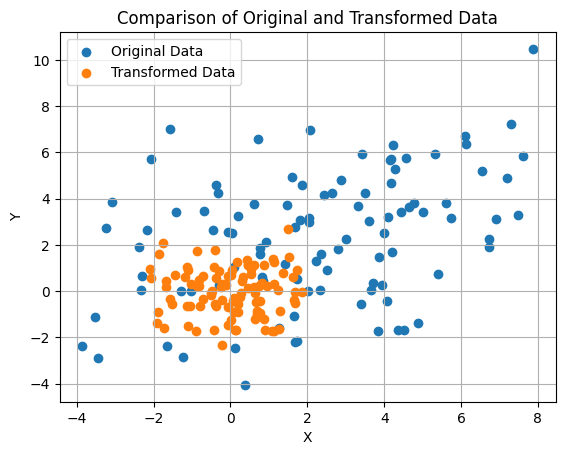

In [5]:
# Extract x and y coordinates from the dataset
x = dataset[:, 0]
y = dataset[:, 1]

# Plot the original data
plt.scatter(x, y, label='Original Data')

# Apply data sphering transformation
Wpca = preformWhitening(dataset)
Wpca_x = Wpca[:, 0]
Wpca_y = Wpca[:, 1]

# Plot the transformed data
plt.scatter(Wpca_x, Wpca_y, label='Transformed Data')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of Original and Transformed Data')
plt.grid(True)
plt.legend()
plt.show()

From the graph the original dataset correlation is weak and so the transformation does center the data but the correlation is not greatly changed

In [6]:
#2d mean of zero and  covariance identy matrix
transformed_mean = np.mean(Wpca, axis=0)
transformed_cov = np.cov(Wpca, rowvar=False)

print("Transformed mean vector:\n", transformed_mean)
print("Transformed covariance matrix:\n", transformed_cov)

Transformed mean vector:
 [ 8.21565038e-17 -3.09752224e-16]
Transformed covariance matrix:
 [[1.01010101e+00 3.43646942e-16]
 [3.43646942e-16 1.01010101e+00]]


In [7]:
# Load the Iris dataset
iris = load_iris()

# Access the attribute data and target labels
X = iris.data  # Attribute data
y = iris.target  # Target labels

In [12]:
def preformPCA(data):
    # Center the data by subtracting the mean vector
    mean_vector = np.mean(data, axis=0)
    centered_data = data - mean_vector

    # Calculate the covariance matrix
    data_cov = np.cov(centered_data, rowvar=False, bias=True)

    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(data_cov)

    # Sort eigenvectors and eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Transform the dataset
    transformed_data = centered_data.dot(sorted_eigenvectors)

    return sorted_eigenvectors, sorted_eigenvalues, transformed_data

In [13]:
sorted_eigenvectors, sorted_eigenvalues, transformed_data = preformPCA(X)

In [18]:
#verify that eigen_vectors are orthonormal
num_eigenvectors = sorted_eigenvectors.shape[1]
is_orthonormal=True
for i in range(num_eigenvectors):
        for j in range(i + 1, num_eigenvectors):
            dot_product = np.dot(sorted_eigenvectors[:, i], sorted_eigenvectors[:, j])
            if not np.isclose(dot_product, 0):
                is_orthonormal = False
                break
print(is_orthonormal)

True


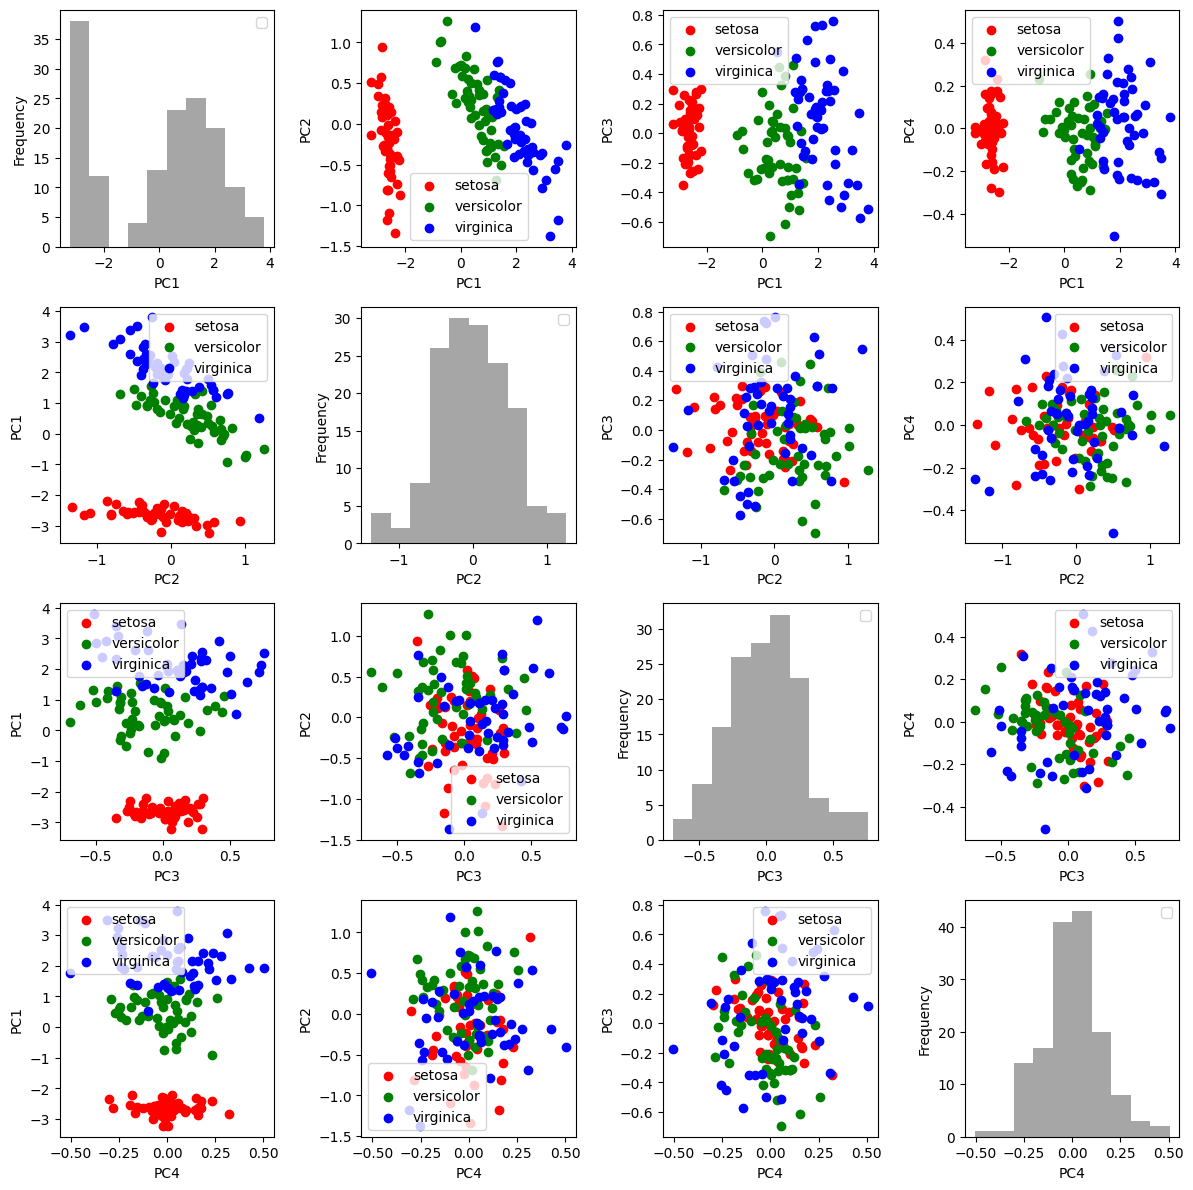

In [19]:
# Create a 4x4 subplot figure
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Set unique colors for each class
colors = ['red', 'green', 'blue']

# Plot each principal component against each other
for i in range(4):
    for j in range(4):
        if i == j:
            # Plot histogram for diagonal elements
            axs[i, j].hist(transformed_data[:, i], color='gray', alpha=0.7)
            axs[i, j].set_xlabel(f'PC{i+1}')
            axs[i, j].set_ylabel('Frequency')
        else:
            # Scatter plot for non-diagonal elements
            for target in np.unique(y):
                axs[i, j].scatter(transformed_data[y == target, i], transformed_data[y == target, j],
                                  color=colors[target], label=iris.target_names[target])
            axs[i, j].set_xlabel(f'PC{i+1}')
            axs[i, j].set_ylabel(f'PC{j+1}')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

It looks like PCA1 and PCA2 separate the 3 classes best and it does make sense because looking at the explained variance the first 2 principle components do capture the greatest variance happening in the data

In [20]:
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)
explained_variance

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In [35]:
def select_pcs_cumulative_variance(explained_variances, desired_variance):
    cumulative_variance = np.cumsum(explained_variances)
    num_pcs = np.argmax(cumulative_variance >= desired_variance) + 1
    return num_pcs
def plot_scree(explained_variances):
    num_pcs = len(explained_variances)
    plt.plot(range(1, num_pcs + 1), explained_variances, 'bo-')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance')
    plt.title('Scree Plot')
    plt.show()
def select_pcs_variance(explained_variances, min_variance):
    num_pcs = np.sum(explained_variances >= min_variance)
    return num_pcs

In [36]:
select_pcs_cumulative_variance(explained_variance, 0.02)

1

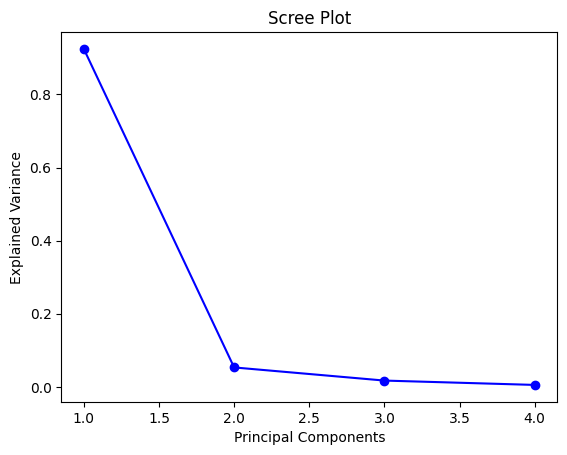

In [27]:
plot_scree(explained_variance)

In [31]:
select_pcs_variance(explained_variance, 0.02)

2

Exercises 2.1

Generate n = 50, p = 3 normally distributed random variables that
have high variance in one dimension.
Try PCA using both correlation and covariance matrices.

Is the one with the covariance matrix very informative? Which one would be
better to use in this case?

In [34]:
n = 50  # Number of samples
p = 3   # Number of dimensions

# Generate random variables with high variance in the first dimension
X = np.zeros((n, p))
X[:, 0] = np.random.normal(loc=0, scale=10, size=n)
X[:, 1:] = np.random.normal(loc=0, scale=1, size=(n, p-1))
# Perform PCA with correlation matrix
pca_correlation = PCA(n_components=p)
X_correlation = pca_correlation.fit_transform(X)

# Perform PCA with covariance matrix
pca_covariance = PCA(n_components=p, svd_solver='full')
X_covariance = pca_covariance.fit_transform(X)

explained_variance_ratio_correlation = pca_correlation.explained_variance_ratio_
explained_variance_ratio_covariance = pca_covariance.explained_variance_ratio_

print('Explained Variance Ratio (Correlation Matrix):', explained_variance_ratio_correlation)
print('Explained Variance Ratio (Covariance Matrix):', explained_variance_ratio_covariance)

Explained Variance Ratio (Correlation Matrix): [0.9862099  0.00877875 0.00501134]
Explained Variance Ratio (Covariance Matrix): [0.9862099  0.00877875 0.00501134]


Usually using covariance matrix with pca is highly recommended to capture the variance but in this case for this simple data it doesnot seem to be much difference between using either